# Advantages of Automatic Differentiation

The availability of an automatic differentiation framework within a CFD simulation engine has more advantages besides machine learning. PyTorch provides analytic derivatives for all numerical operations, which is for example useful in flow control and optimization. 

As a demonstration of these capabilities, a forced isotropic turbulence is simulated, i.e. the energy spectrum is maintained throughout the simulation without further constraining the velocity field. A restraint $R$ is defined as the relative deviation of the instantaneous spectrum $\sigma(u)$ from the target spectrum $\sigma_0$ with a cutoff at $c:=2\cdot 10^{-5}.$ Concretely,

$$
R(u) = \left(\ln \max(\sigma(u), c) -  \ln \max(\sigma_0, c) \right)^2,
$$

where the $\max$ operation is defined elementwise.

To incorportate this restraint into the simulation, the equilibrium distribution $f^\mathrm{eq}(\rho, u+\Delta u)$ is developed around a velocity that is locally shifted by a forcing term $\Delta u := -k \cdot \nabla R$ with a force constant $k=5\cdot 10^{-5}.$ Computing the gradient requires differentiating through various numeric operations, including a Fast Fourier Transform, which is only possible due to the automatic differentiation within PyTorch.

Figure ... shows the vorticity fields and energy spectra for a simulation at a resolution of 128$^2$ grid points with $Re=5000$ and $Ma=0.05.$ While the unrestrained simulation decays, the restrained simulation maintains the spectrum. This example shows that complicated restraints can be easily incorporated into simulations. This feature can be can be useful in many other applications.


In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np

## Spectrum Maintainer

In [2]:
import torch

    
class SpectrumTargetingEquilibrium(lt.QuadraticEquilibrium):
    cutoff = 2e-5
    
    def __init__(self, lattice, flow, target_spectrum=None):
        self.spectrum_observable = lt.EnergySpectrum(lattice, flow)
        self.target_spectrum = target_spectrum
        super(SpectrumTargetingEquilibrium, self).__init__(lattice)
        
    def __call__(self, rho, u):
        u.requires_grad = True
        spectrum = self.spectrum_observable.spectrum_from_u(u)
        loss = self.restraint(spectrum)
        loss.backward()
        u.requires_grad = False
        unew = u - 5e-5*u.grad
        return super(SpectrumTargetingEquilibrium, self).__call__(rho, unew)
    
    def restraint(self, spectrum):
        m1 = torch.max(torch.stack(
            [
                spectrum[:-20], 
                self.cutoff*torch.ones_like(spectrum[:-20])
            ]
        ), axis=0)[0]
        m2 = torch.max(torch.stack(
            [
                self.target_spectrum[:-20], 
                self.cutoff*torch.ones_like(self.target_spectrum[:-20])
             ]
        ),axis=0)[0]
        loss = ((torch.log(m1) - torch.log(m2))**2).sum()
        return loss



## Setup
The setup is the same as for a decaying turbulence simulation.

In [3]:
class UReporter: 
    """A reporter to write out the velocity field."""
    def __init__(self, lattice, flow, interval=100):
        self.flow = flow
        self.lattice = lattice
        self.interval = interval
        self.out = []
    def __call__(self, i, t, f): 
        u = self.lattice.u(f).clone()
        if i % self.interval == 0:
            self.out.append(
                [i, t, self.flow.units.convert_velocity_to_pu(u)]
            )

In [4]:
lattice = lt.Lattice(lt.D2Q9, device = "cpu")
flow = lt.DecayingTurbulence(
    resolution=128, 
    reynolds_number=5000, 
    mach_number=0.05, 
    lattice=lattice
)
_ = flow.initial_solution(flow.grid) # initialize spectrum

In [5]:
def simulate(use_force=True, n_steps=2000, interval=500):
    """simulate the flow with or without the force. 
    Returns spectrum and velocities.
    """
    # create simulation
    lattice = lt.Lattice(lt.D2Q9, device = "cpu")
    flow = lt.DecayingTurbulence(
        resolution=128, 
        reynolds_number=5000, 
        mach_number=0.05, 
        lattice=lattice
    )
    collision = lt.BGKCollision(
        lattice, 
        tau=flow.units.relaxation_parameter_lu
    )
    streaming = lt.StandardStreaming(lattice)
    simulation = lt.Simulation(
        flow=flow,
        lattice=lattice,
        collision=collision,
        streaming=streaming
    )
    # replace equilibrium to maintain spectrum
    energyspectrum = lt.EnergySpectrum(lattice, flow)
    if use_force:
        feq = SpectrumTargetingEquilibrium(
            lattice, 
            flow, 
            energyspectrum(simulation.f)
        )
    else:
        feq = lt.QuadraticEquilibrium(lattice)
    simulation.lattice.equilibrium = feq
    # add reporters
    reporter = lt.ObservableReporter(
        energyspectrum, 
        interval=interval, 
        out=None
    )
    simulation.reporters.append(reporter)
    velocity_reporter = UReporter(lattice, flow, interval=interval)
    simulation.reporters.append(velocity_reporter)
    # simulate and return results
    simulation.step(n_steps)
    return reporter.out, velocity_reporter.out

Run simulations

In [6]:
spectrum_targeted, u_targeted = simulate()
spectrum_standard, u_standard = simulate(use_force=False)

steps     time     EnergySpectrum
steps     time     EnergySpectrum


## Plots

In [7]:
def vorticity_plot(ax, u):
    dx = flow.units.convert_length_to_pu(1.0)
    grad_u0 = np.gradient(u[0], dx)
    grad_u1 = np.gradient(u[1], dx)
    vorticity = (grad_u1[0] - grad_u0[1])
    image = ax.imshow(vorticity, cmap='seismic', vmin=-10, vmax=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return image

In [8]:
def spectrum_plot(ax, spectrum_out):
    ax.semilogy()
    ax.set_ylim(1e-5, 1e-1)
    ax.set_xlim(0,50)
    ax.plot(
        flow.energy_spectrum[1], 
        spectrum_out[0][2:], 
        lw=2, label="Step 0"
    )
    ax.plot(
        flow.energy_spectrum[1], 
        spectrum_out[2][2:],
        "--", lw=2, label="Step 1000"
    )
    ax.plot(
        flow.energy_spectrum[1], 
        spectrum_out[4][2:], 
        ":", lw=2, color="black",label="Step 2000"
    )

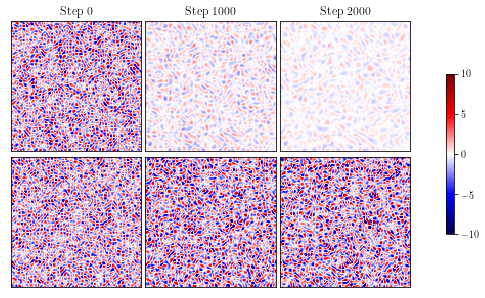

In [9]:
import matplotlib
fig, axes = plt.subplots(
    2, 3, figsize=(10,4), 
    sharex=True, sharey=True
)

im1 = vorticity_plot(axes[0,0], u_standard[0][2])
im2 = vorticity_plot(axes[0,1], u_standard[2][2])
im3 = vorticity_plot(axes[0,2], u_standard[4][2])

im4 = vorticity_plot(axes[1,0], u_targeted[0][2])
im5 = vorticity_plot(axes[1,1], u_targeted[2][2])
im6 = vorticity_plot(axes[1,2], u_targeted[4][2])
axes[0,0].set_title("Step 0")
axes[0,1].set_title("Step 1000")
axes[0,2].set_title("Step 2000")

plt.tight_layout(pad=0.2, w_pad=-15.0)

fig.colorbar(im1, ax=axes[:,:], shrink=0.6, )
fig.savefig("forced.png", dpi=360, bbox_inches="tight")

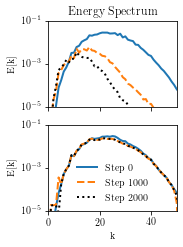

In [15]:
fig, axes = plt.subplots(
    2, 1, figsize=(2.3,3.5), 
    sharex=True, sharey=True
)

spectrum_plot(axes[0], spectrum_standard)
spectrum_plot(axes[1], spectrum_targeted)

axes[0].set_title("Energy Spectrum")

axes[1].legend(frameon=False)
axes[1].set_xlabel("k")
axes[0].set_ylabel("E[k]")

axes[1].set_ylabel("E[k]")
fig.savefig("forced_spectrum.png", dpi=360, bbox_inches="tight")